# Baseline model
Will develop the functions needed to build a model. This will be a simple model to get started such as a decision tree or random forest. Reason for this is that we don't have to put too much effort into feature selection since we can easily regularise the depth of a decision tree (to prevent overfitting) and random forests wont overfit given the errors of the week learners are not correlated.

In [1]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, log_loss
from sklearn.preprocessing import StandardScaler
from data.load_sim_data import load_sim_features

pd.options.display.float_format = "{:.1f}".format

In [2]:
features = load_sim_features()

Plan
- remove useless features
- split train, validate, test (give reason for delay)
- build some metric functions. Recall, AUC, etc
- pipeline function for testing multiple models

### Split data
In reality, you would probably not know if a transaction was fraudulent on the Monday if you were predicting for the Tuesday. Given this can take time to be flagged, I will give a 1-week delay between the train and validation sets, and the test set will be the week after the validation

We do not shuffle the data before a split since it is a time series. It doesn't make sense to train a model on September data then test it on August.

In [3]:
def calculate_date_splits(start_dt, end_dt, day_delay, test_vali_size):
    train_start = datetime.datetime.strptime(start_dt, "%Y-%m-%d")
    test_end = datetime.datetime.strptime(end_dt, "%Y-%m-%d")
    test_start = test_end - datetime.timedelta(days=test_vali_size-1)
    vali_end = test_start - datetime.timedelta(days=1)
    vali_start = vali_end - datetime.timedelta(days=test_vali_size-1)
    train_end = vali_start - datetime.timedelta(days=day_delay)

    if not train_start < train_end < vali_start < vali_end < test_start < test_end:
        print(train_start.date())
        print(train_end.date())
        print(vali_start.date())
        print(vali_end.date())
        print(test_start.date())
        print(test_end.date())
        raise ValueError('Arguments done make sense since there is overlap between the dataset')

    return train_start, train_end, vali_start, vali_end, test_start, test_end

In [4]:
def split_train_vali_test(features, start_dt, end_dt, day_delay = 7, test_vali_size = 7):
    train_start,\
    train_end,\
    vali_start,\
    vali_end,\
    test_start,\
    test_end = calculate_date_splits(start_dt, end_dt, day_delay, test_vali_size)

    train = features[features['TX_DATE'].between(train_start, train_end, inclusive='both')]
    vali = features[features['TX_DATE'].between(vali_start, vali_end, inclusive='both')]
    test = features[features['TX_DATE'].between(test_start, test_end, inclusive='both')]

    return train, vali, test

In [5]:
# Set date range
start_dt = '2018-08-01'
end_dt = '2018-09-30'
day_delay = 7
test_vali_size = 7

In [6]:
# Plot splits
def get_count_stats(features):
    txn_count = features[['TX_DATE', 'TRANSACTION_ID']].groupby('TX_DATE').count()
    txn_fraud_count = features[features['TX_FRAUD'] == 1][['TX_DATE', 'TRANSACTION_ID']].groupby('TX_DATE').count()
    card_fraud_count = features[features['TX_FRAUD'] == 1][['TX_DATE', 'CUSTOMER_ID']].groupby('TX_DATE').nunique('CUSTOMER_ID')

    txn_count.columns = ['TXN_COUNT']
    txn_fraud_count.columns = ['TXN_FRAUD_COUNT']
    card_fraud_count.columns = ['COMPROMISED_CARDS']

    count_stats = pd.concat([txn_count, txn_fraud_count, card_fraud_count], axis=1)
    return count_stats

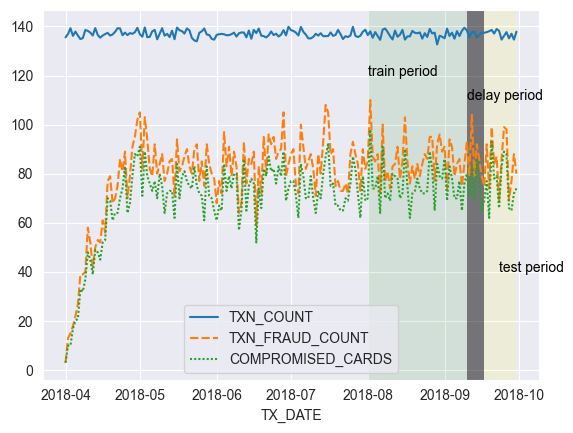

In [7]:
# Plot ts
def plot_ts_stats(features, start_dt, end_dt, day_delay, test_vali_size):
    count_stats = get_count_stats(features)
    count_stats['TXN_COUNT'] /=70 # adjust to fit on plot (easier than tuning a second axis since we just want a rough idea)

    train_start,\
    train_end,\
    vali_start,\
    vali_end,\
    test_start,\
    test_end = calculate_date_splits(start_dt, end_dt, day_delay = 7, test_vali_size = 7)

    plt1 = sns.lineplot(data=count_stats)
    plt1.axvspan(train_start, train_end, color='green', alpha=0.1, lw=0)
    plt1.text(train_start, 120, 'train period', color='black')
    plt1.axvspan(train_end, vali_start, color='black', alpha=0.5, lw=0)
    plt1.text(train_end, 110, 'delay period', color='black')
    plt1.axvspan(vali_start, test_end, color='yellow', alpha=0.1, lw=0)
    plt1.text(vali_end, 40, 'test period', color='black')

    return plt1

plt_ts = plot_ts_stats(features, start_dt, end_dt, day_delay, test_vali_size)
plt.show()

In [8]:
# Split dataset
train, vali, test = split_train_vali_test(features, start_dt, end_dt, day_delay, test_vali_size)

In [9]:
# Check date ranges
print('Train min: ', train['TX_DATE'].min())
print('Train max: ', train['TX_DATE'].max())
print('Vali min:  ', vali['TX_DATE'].min())
print('Vali max:  ', vali['TX_DATE'].max())
print('Test min:  ', test['TX_DATE'].min())
print('Test max:  ', test['TX_DATE'].max())

Train min:  2018-08-01 00:00:00
Train max:  2018-09-10 00:00:00
Vali min:   2018-09-17 00:00:00
Vali max:   2018-09-23 00:00:00
Test min:   2018-09-24 00:00:00
Test max:   2018-09-30 00:00:00


### Remove useless features
Such as txn id, etc

In [10]:
selected_features = [
  'TX_AMOUNT'
, 'TX_FRAUD'
, 'TX_ON_WEEKEND'
, 'TX_AT_NIGHT'
, 'CUSTOMER_ID_1_DAY_WINDOW_SUM_AMOUNT'
, 'CUSTOMER_ID_1_DAY_WINDOW_COUNT'
, 'CUSTOMER_ID_1_DAY_WINDOW_AVG_AMOUNT'
, 'CUSTOMER_ID_7_DAY_WINDOW_SUM_AMOUNT'
, 'CUSTOMER_ID_7_DAY_WINDOW_COUNT'
, 'CUSTOMER_ID_7_DAY_WINDOW_AVG_AMOUNT'
, 'CUSTOMER_ID_30_DAY_WINDOW_SUM_AMOUNT'
, 'CUSTOMER_ID_30_DAY_WINDOW_COUNT'
, 'CUSTOMER_ID_30_DAY_WINDOW_AVG_AMOUNT'
, 'CUSTOMER_ID_DAYS_SINCE_LAST_TXN'
, 'TERMINAL_ID_FRAUD_RISK_1_DAY_WINDOW'
, 'TERMINAL_ID_FRAUD_RISK_7_DAY_WINDOW'
, 'TERMINAL_ID_FRAUD_RISK_30_DAY_WINDOW'
, 'TERMINAL_ID_FRAUD_TXN_COUNT_1_DAY_WINDOW'
, 'TERMINAL_ID_FRAUD_TXN_COUNT_7_DAY_WINDOW'
, 'TERMINAL_ID_FRAUD_TXN_COUNT_30_DAY_WINDOW'
]
train = train[selected_features]
vali = vali[selected_features]
test = test[selected_features]

### Check train, vali and test are reasonably similar

In [11]:
print(train.shape)
print(vali.shape)
print(test.shape)

(392670, 20)
(67611, 20)
(66715, 20)


In [12]:
print(train['TX_FRAUD'].sum()/len(train))
print(vali['TX_FRAUD'].sum()/len(vali))
print(test['TX_FRAUD'].sum()/len(test))

0.008964270252374767
0.008578485749360312
0.008948512328561793


Looks reasonable. This dataset is very imbalanced, but we will attempt to model without addressing first

### Separate out label

In [13]:
label = 'TX_FRAUD'
remaining_features = [feature for feature in selected_features if feature != label]

In [14]:
train_label = train[label]
train.drop(label, axis=1, inplace=True)
vali_label = vali[label]
vali.drop(label, axis=1, inplace=True)
test_label = test[label]
test.drop(label, axis=1, inplace=True)

### Scale the dataset for GD algos, etc

In [15]:
features_to_avoid_scaling = ['TX_ON_WEEKEND', 'TX_AT_NIGHT']
scaled_features = [feature for feature in remaining_features if feature not in features_to_avoid_scaling]

scaler = StandardScaler()

train[scaled_features] = scaler.fit_transform(train[scaled_features])
vali[scaled_features] = scaler.fit_transform(vali[scaled_features])
test[scaled_features] = scaler.fit_transform(test[scaled_features])

No binning, OHE or anything else needs to be done right now

### First baseline model - Decision tree

In [16]:
model = DecisionTreeClassifier()

# Given RF cannot overfit we throw all features it's way
model.fit(train, train_label)
pred = model.predict(vali)

print(classification_report(vali_label, pred))

pred_proba = model.predict_proba(vali)
ll = log_loss(vali_label, pred_proba)
print("Log Loss for logistic model is {0:.3f}".format(ll))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     67031
           1       0.52      0.72      0.60       580

    accuracy                           0.99     67611
   macro avg       0.76      0.85      0.80     67611
weighted avg       0.99      0.99      0.99     67611

Log Loss for logistic model is 0.278


In [17]:
model.get_n_leaves() # many leaves, could do with some pruning

1844

Accuracy is high because it is predicting mostly 0s for this heavily 0 balanced dataset.
Recall is 72% but precision is only 56%. Still doesn't look too bad for a single decision tree with absolutely no hyperparams changed.
Will need to build some more useful metrics to check this.